# Two Market Makers

This notebook corresponds to section 4 (**Agent based models**) of "Market Based Mechanisms for Incentivising Exchange Liquidity Provision" available [here](https://vega.xyz/papers/liquidity.pdf). It models two market makers.

In [1]:
import math, sys 
import numpy as np
from scipy import sparse
from scipy.sparse import diags
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from os import path
count = 0

from matplotlib.backends.backend_pdf import PdfPages

In [2]:
T = 1;
gamma = 0.1

sigma0 = 0.1
sigma1 = 0.1
lambd = 0.1
r = 0.02
rRisk0 = 0.01 
rRisk1 = 0.01

# This is the key; how does instantenaous trading volume react 
# to market making stake
# and to fees

def fee_volume_response(f):
    f = np.maximum(f, np.zeros(np.size(f)))
    f = np.minimum(f, np.ones(np.size(f)))
    return 1.0/(f+0.001) - f



def stake_volume_response(S):
    return 1.0 / (1+np.exp(-0.05*S+2)) - 1.0 / (1+np.exp(2))

# The actual trading and slashing
# Agent index is still an input as they know their cost of capital
# def running_gain_true(t,f,S,agent_idx):
#     rRisk = (agent_idx == 0) * rRisk0 + (agent_idx == 1) * rRisk1
#     return np.exp(-r*t) * (f * trading_volume_true(f,S) - lambd * sigma_true * S) - np.exp(rRisk*t)*S

# Agents' assumption about trading volume
# S should be vector of all agents' current stake
def trading_volume_agt(f,S,agent_idx):
    N_max = (agent_idx == 0) * 20000 + (agent_idx == 1) * 20000 
    total_S = np.sum(S) 
    if total_S <= 0: 
        return 0
    return  (S[agent_idx]/total_S ) * N_max * fee_volume_response(f) * stake_volume_response(total_S)

# Running gain assumption by various agents
# S should be vector of all agents' current stake
def running_gain_agt(t,f,S,agent_idx):
    return (agent_idx == 0) * (np.exp(-r*t) * (f * trading_volume_agt(f,S,agent_idx) - lambd * sigma0 * S[agent_idx])  - np.exp(rRisk0*t)*S[agent_idx]) \
            + (agent_idx == 1) * (np.exp(-r*t) * (f * trading_volume_agt(f,S,agent_idx) - lambd * sigma1 * S[agent_idx]) - np.exp(rRisk1*t)*S[agent_idx])
    


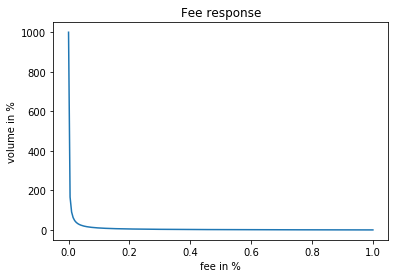

In [3]:
x_span = np.linspace(0,1, 200) 
y = fee_volume_response(x_span)
plt.xlabel('fee in %')
plt.ylabel('volume in %')
plt.title('Fee response')
plt.plot(x_span,y)

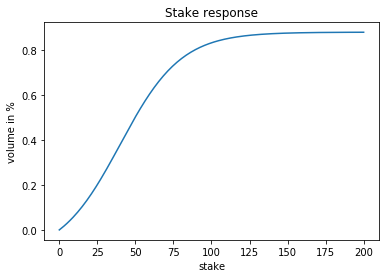

In [4]:
x_span = np.linspace(0,200, 200) 
y = stake_volume_response(x_span)
plt.xlabel('stake')
plt.ylabel('volume in %')
plt.title('Stake response')
plt.plot(x_span,y)

In [5]:
# Discretization parameter initialization 

L_S = 120;
L_f = 1;

N_T = 5; delta_t = T / (N_T-1);
N_S = 15; 
N_f = 15; 

t_span = np.linspace(0,T, N_T)
f_span = np.linspace(0, L_f, N_f)
S_span = np.linspace(0, L_S, N_S)

In [6]:
# Control space definition     

m = 3
controls_lookup = np.matrix([
                     [0,-m], 
                     [1,0], 
                     [2,m],
])        



In [7]:
def grid_idx_from(S,S_span):
    min_S = S_span[0]
    N_S = np.size(S_span)
    max_S = S_span[N_S-1]
    delta_S = (max_S-min_S)/(N_S-1)
    return max(min(int(round(S/delta_S)), N_S-1),0)


def update_value_at_time_idx(t_idx, a_vals, v_vals_old, v_vals_new, agent_idx):
    for f_idx in range(0,N_f):
        for S_idx0 in range(0,N_S):
            for S_idx1 in range(0,N_S):
                # if both want to increase stake then the fee should go down
                # if both want to decrease stake then the fee should go up 
                # otherwise (only one is changing stake) fee stays the same
                a_0 = a_vals[0, t_idx, f_idx, S_idx0, S_idx1]
                a_1 = a_vals[1, t_idx, f_idx, S_idx0, S_idx1]
                effective_a = (a_0 > 0) * (a_1 > 0) * a_0 + (a_0 < 0) * (a_1 < 0) * a_0
            
                f_new = f_span[f_idx] - gamma * effective_a * delta_t 
                S_new0 = S_span[S_idx0] + a_0 * delta_t 
                S_new1 = S_span[S_idx1] + a_1 * delta_t 
                t_new = t_span[t_idx] 
            
                f_new_idx = grid_idx_from(f_new,f_span)
                
                S_new_idx0 = grid_idx_from(S_new0,S_span)
                S_new_idx1 = grid_idx_from(S_new1,S_span)
                S_new = np.array([S_new0,S_new1])
                v_vals_new[agent_idx, t_idx, f_idx, S_idx0, S_idx1] = running_gain_agt(t_new, f_new, S_new, agent_idx)*delta_t \
                        + v_vals_old[agent_idx, t_idx+1, f_new_idx, S_new_idx0, S_new_idx1]


def update_value(a_vals, v_vals_old, v_vals_new, agent_idx):
    for t_idx in reversed(range(0,N_T-1)):
        update_value_at_time_idx(t_idx, a_vals, v_vals_old, v_vals_new, agent_idx)
        



# When agents are optimizing their actions they need to use their assumptions
def calculate_one_step_gain(t_idx, f_idx, S_idx0, S_idx1, a_vals, v_vals, agent_idx):
    t_new = t_span[t_idx] 
    gains = np.zeros(np.size(controls_lookup[:,1]))
    
    # Agent 0 first
    if agent_idx == 0:
        for a0_idx in range(0,np.size(controls_lookup[:,1])):
            a0 = controls_lookup[a0_idx,1]
            # Other agent i.e. agent 1 is doing what their policy says
            a1 = a_vals[1, t_idx, f_idx, S_idx0, S_idx1]
            a_f = (a0 > 0) * (a1 > 0) * a0 + (a0 < 0) * (a1 < 0) * a0
            f_new = f_span[f_idx] - gamma * a_f * delta_t 
            S_new0 = S_span[S_idx0] + a0 * delta_t 
            S_new1 = S_span[S_idx1] + a1 * delta_t 
            S_new = np.array([S_new0,S_new1])
            
            f_new_idx = int(max(min(f_idx - a_f, N_f-1),0))
            S_new_idx0 = int(max(min(S_idx0 + a0, N_S-1),0))
            S_new_idx1 = int(max(min(S_idx1 + a1, N_S-1),0))
            
            gains[a0_idx] = running_gain_agt(t_new, f_new, S_new, agent_idx)*delta_t \
                            + v_vals[agent_idx,t_idx+1, f_new_idx, S_new_idx0, S_new_idx1]
        return gains

    # Agent 1 next is the same as above except the roles are reversed
    else:
        for a1_idx in range(0,np.size(controls_lookup[:,1])):
            a1 = controls_lookup[a1_idx,1]
            # Other agent i.e. agent 1 is doing what their policy says
            a0 = a_vals[0, t_idx, f_idx, S_idx0, S_idx1]
            a_f = (a0 > 0) * (a1 > 0) * a0 + (a0 < 0) * (a1 < 0) * a0
            f_new = f_span[f_idx] - gamma * a_f * delta_t 
            S_new0 = S_span[S_idx0] + a0 * delta_t 
            S_new1 = S_span[S_idx1] + a1 * delta_t 
            S_new = np.array([S_new0,S_new1])
            
            f_new_idx = int(max(min(f_idx - a_f, N_f-1),0))
            S_new_idx0 = int(max(min(S_idx0 + a0, N_S-1),0))
            S_new_idx1 = int(max(min(S_idx1 + a1, N_S-1),0))
            
            
            gains[a1_idx] = running_gain_agt(t_new, f_new, S_new, agent_idx)*delta_t \
                            + v_vals[agent_idx,t_idx+1, f_new_idx, S_new_idx0, S_new_idx1]
        return gains



            
        
def update_policy_at_time_idx(t_idx, v_vals, a_vals, agent_idx):
    for f_idx in range(0,N_f):
        for S_idx0 in range(0,N_S):
            for S_idx1 in range(0,N_S):
                gains = calculate_one_step_gain(t_idx, f_idx, S_idx0, S_idx1, a_vals, v_vals, agent_idx)
                idx_maximizing = np.argmax(gains)
                a_vals[agent_idx, t_idx, f_idx, S_idx0, S_idx1] = controls_lookup[idx_maximizing,1]
        
def update_policy(v_vals, a_vals, agent_idx):
    for t_idx in reversed(range(0,N_T-1)):
        update_policy_at_time_idx(t_idx, v_vals, a_vals, agent_idx)

In [8]:
max_iter = 10
max_err = 3/(N_f*N_S)

v_vals_new = np.zeros((2, np.size(t_span),np.size(f_span), np.size(S_span), np.size(S_span)))
v_vals_old = np.zeros((2, np.size(t_span),np.size(f_span), np.size(S_span), np.size(S_span)))
a_vals = np.ones((2, np.size(t_span),np.size(f_span), np.size(S_span), np.size(S_span)))
a_vals_old = np.ones((2, np.size(t_span),np.size(f_span), np.size(S_span), np.size(S_span)))
for iter_idx in range(0,max_iter):
    # update agents' value functions with given control
    update_value(a_vals, v_vals_old, v_vals_new, 0)
    update_value(a_vals, v_vals_old, v_vals_new, 1)
    
    # make a copy of policy response for comparison purposes
    a_vals_old = np.copy(a_vals)
    
    # update agents' policies
    update_policy(v_vals_new, a_vals, 0)
    update_policy(v_vals_new, a_vals, 1)
    
    # calculate how much we are still changing
    diff_pol = np.sum(np.abs(a_vals_old - a_vals))/(N_f*N_S)
    
    v_vals_old = np.copy(v_vals_new)
        
    if (diff_pol < 1e-8):
        print('Converged; change in policy fn. {0:1.5e}'.format(diff_pol))
        break
    else:
        print('Will run another iteration; change in policy fn. {0:1.5e}'.format(diff_pol))



Will run another iteration; change in policy fn. 2.45956e+02
Will run another iteration; change in policy fn. 3.74800e+01
Will run another iteration; change in policy fn. 8.29333e+00
Will run another iteration; change in policy fn. 9.06667e-01
Will run another iteration; change in policy fn. 8.00000e-02
Will run another iteration; change in policy fn. 2.66667e-02
Converged; change in policy fn. 0.00000e+00


Text(0.5, 0, 'value')

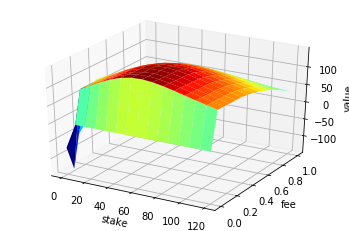

In [9]:
plotGridX, plotGridY = np.meshgrid(S_span, f_span)
fig = plt.figure()
ax1 = fig.gca(projection='3d')
surf = ax1.plot_surface(plotGridX, plotGridY, v_vals_new[1,0,:,:,0],linewidth=0, cmap=cm.jet, antialiased=True)
ax1.set_xlabel('stake')
ax1.set_ylabel('fee')
ax1.set_zlabel('value')

Text(0.5, 0, 'a')

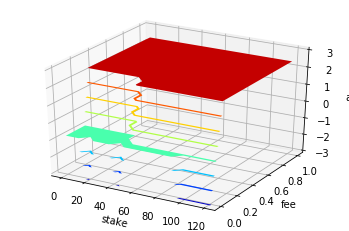

In [10]:
plotGridX, plotGridY =  np.meshgrid(S_span, f_span)

fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')

surf = ax1.contourf(plotGridX, plotGridY, a_vals[0,0,:,14,:], cmap=cm.jet, antialiased=True)
ax1.set_xlabel('stake')
ax1.set_ylabel('fee')
ax1.set_zlabel('a')

Text(0, 0.5, 'fees')

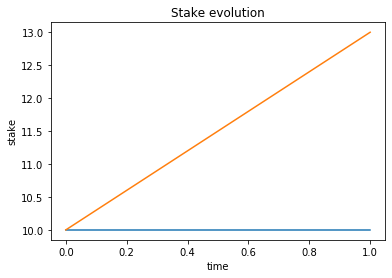

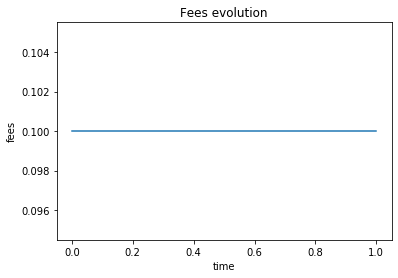

In [11]:
stakes0 = np.zeros(N_T+1)
stakes1 = np.zeros(N_T+1)
stakes0[0] = 10
stakes1[0] = 10
fees = np.zeros(N_T+1)
fees[0] = 0.1

actions = np.zeros(N_T+1)
for i in range(0,N_T):
    f_idx = grid_idx_from(fees[i],f_span)
    S_idx0 = grid_idx_from(stakes0[i],S_span)
    S_idx1 = grid_idx_from(stakes1[i],S_span)
    
    a_0 = a_vals[0, i, f_idx, S_idx0, S_idx1]
    a_1 = a_vals[1, i, f_idx, S_idx0, S_idx1]
    a_fee = (a_0 > 0) * (a_1 > 0) * a_0 + (a_0 < 0) * (a_1 < 0) * a_0 
    

    fees[i+1] = fees[i] - gamma * a_fee * delta_t
    stakes0[i+1] = stakes0[i] + a_0 * delta_t
    stakes1[i+1] = stakes1[i] + a_1 * delta_t

plt.plot(t_span, stakes0[0:N_T])
plt.plot(t_span, stakes1[0:N_T])
plt.title('Stake evolution')
plt.xlabel('time')
plt.ylabel('stake')
fig = plt.figure()
plt.plot(t_span, fees[0:N_T])
plt.title('Fees evolution')
plt.xlabel('time')
plt.ylabel('fees')



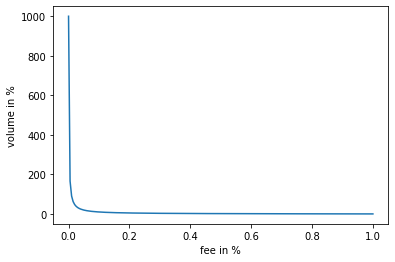

In [12]:
x_span = np.linspace(0,1, 200) 
y = fee_volume_response(x_span)
plt.xlabel('fee in %')
plt.ylabel('volume in %')
plt.plot(x_span,y)

In [13]:
y[100]

1.4835352021336838